# Data Exploration and Analysis

In [6]:
## Load all days into a single dataframe
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from globes import taxi_dir, days_dir
from multiprocessing import Pool, Process, cpu_count

## get X, y in numpy arrays from relevant data
FEATURE_COLS = [
                'pickup_day', 
                'pickup_hour', 
                'pickup_zone_taxi', 
                'dropoff_zone_taxi', 
                'pickup_borough', 
                'dropoff_borough'
               ]

""" get feature and label rows from filename
"""
def get_df(filename):
    df = pd.read_csv(filename, parse_dates=['pickup_datetime', 'dropoff_datetime'])
    
    # get rid of zones that don't actually really exist
    df = df.loc[df['pickup_zone_taxi'] != -1]
    df = df.loc[df['dropoff_zone_taxi'] != -1]
    df = df.dropna()
    
    df['pickup_zone_taxi'] = df['pickup_zone_taxi'].apply(int)
    df['dropoff_zone_taxi'] = df['dropoff_zone_taxi'].apply(int)
    
    df["pickup_day"] = df['pickup_datetime'].apply(lambda t: t.weekday())
    df["pickup_hour"] = df['pickup_datetime'].apply(lambda t: t.hour)

    df = df[FEATURE_COLS]
    return df

""" get X, y in numpy arrays from relevant data
"""
def getData():
    num_cores = cpu_count()/2
    print "using " + str(num_cores) + " cores"
    pool = Pool(processes=num_cores)
    
    filenames = [os.path.join(taxi_dir, days_dir, f) for f in os.listdir(os.path.join(taxi_dir, days_dir)) if f.endswith('csv')]

    # get dataframes in parallel
    df_arr = pool.map(get_df, filenames)
    pool.terminate()
    
    # concatenate dataframe array into single df
    df = pd.concat(df_arr)

    print df.shape
    return df

df = getData()

using 28 cores
(77699460, 6)


In [26]:
## GET ZONE => NAME and ZONE => BOROUGH json 
import json

from globes import zoneIdToName, zoneIdToBorough

zoneToName = zoneIdToName()
zoneToBorough = zoneIdToBorough()

## Destination proportions

In [8]:
# given a df, return a dictionary of pickup zone id => dataframe of dropoff zones
# sorted by proportion/count
def getDestCounts(df):
    dest_dfs = {}
    pickup_zones = df.groupby('pickup_zone_taxi')
    for pickup_zone, rides in pickup_zones:
        count_df = pd.DataFrame(rides.groupby('dropoff_zone_taxi').size().rename('count'))
        count_df = count_df.sort_values(by="count", ascending=False)
        total_dropoffs = float(count_df["count"].sum())
        count_df["proportion"] = count_df["count"].apply(lambda x: x/total_dropoffs)
        
        dest_dfs[pickup_zone] = count_df
    
    return dest_dfs

# get average top dropoff zone proportion for each borough
def boroughDestCounts(df):
    boroughCounts = {}
    dest_dfs = getDestCounts(df)
    
    # for each pickup zone, put the value of its top proportion 
    # dropoff zone into the appropriate borough array
    for pickup_zone in dest_dfs:
        borough = zoneToBorough[pickup_zone]
        count_df = dest_dfs[pickup_zone]
        top_proportion = count_df["proportion"].iloc[0]
        if not boroughCounts.get(borough):
            boroughCounts[borough] = [top_proportion]
        else:
            boroughCounts[borough].append(top_proportion)
    
    boroughAvgs = {}
    for borough in boroughCounts:
        avg = sum(boroughCounts[borough]) / float(len(boroughCounts[borough]))
        boroughAvgs[borough] = avg
    return boroughAvgs
        

In [ ]:
boroughAvgs = boroughDestCounts(df)
print boroughAvgs

## What's up with Baisley park?

In [37]:
## Baisley park's taxi zone id is 10
BAISLEY = 10
TIMESSQ = 230
def BaisleyPark():
    df_weekdays = df.loc[df['pickup_day'].isin([0, 1, 2, 3, 4])]
    df_weekends = df.loc[df['pickup_day'].isin([5, 6])]
    
    dest_counts1 = getDestCounts(df_weekdays)
    dest_counts2 = getDestCounts(df_weekends)
    print dest_counts1[ID]
    print dest_counts2[ID]
    
## graph hour => proportion Times Sq dropoff
def plotHours(fromID, toID):
    df_from = df.loc[df["pickup_zone_taxi"] == fromID]
    
    # each hour
    hours = [h for h in range(0, 24)]
    hour_dest_proportions = []
    for h in hours:
        df_hour = df_from.loc[df_from["pickup_hour"] == h]
        dest_counts = getDestCounts(df_hour)[fromID]
        prop = dest_counts.loc[dest_counts.index == toID].iloc[0]["proportion"]
        hour_dest_proportions.append(prop)
    
    # y = hour_dest_proportions, x = hours
    with plt.style.context('ggplot'):
        plt.plot(hours, hour_dest_proportions)
        plt.xlabel('Hour of day')
        plt.ylabel('Proportion of dropoffs in ' + zoneToName[toID])
        plt.title('Proportion of dropoffs in ' + zoneToName[toID] + ' by hour')
        plt.show()


## graph DoW => proportion Times Sq dropoff
def plotDays(fromID, toID):
    df_from = df.loc[df["pickup_zone_taxi"] == fromID]
    
    # each day of week
    days = [d for d in range(0, 7)]
    day_dest_proportions = []
    for d in days:
        df_day = df_from.loc[df_from["pickup_day"] == d]
        dest_counts = getDestCounts(df_day)[fromID]
        prop = dest_counts.loc[dest_counts.index == toID].iloc[0]["proportion"]
        day_dest_proportions.append(prop)
    
    # y = day_dest_proportions, x = days
    with plt.style.context('ggplot'):
        plt.plot(days, day_dest_proportions)
        plt.xlabel('Day of week')
        plt.ylabel('Proportion dropoffs in ' + zoneToName[toID])
        plt.title('Proportion dropoffs in ' + zoneToName[toID] + ' by day')
        plt.show()


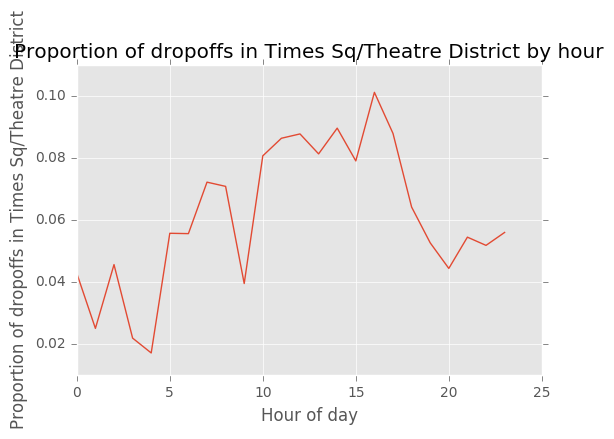

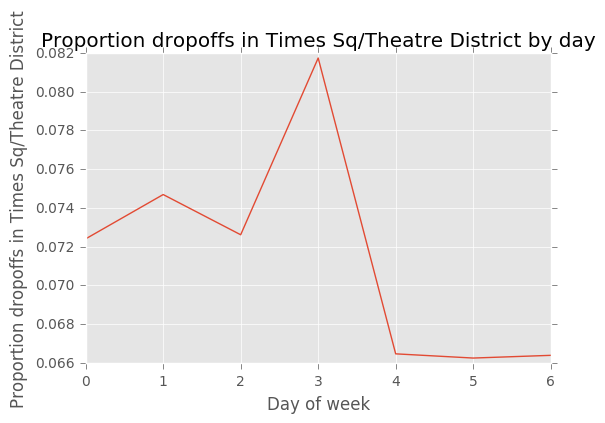

In [38]:
plotHours(BAISLEY, TIMESSQ)
plotDays(BAISLEY, TIMESSQ)

## When are people traveling around

## North Williamsburg vs. South Williamsburg